# Define

In [2]:
import datajoint as dj

schema = dj.schema('university')


[2023-08-30 00:26:05,507][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-08-30 00:26:05,519][INFO]: Connected root@fakeservices.datajoint.io:3306


In [3]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    home_address    : varchar(120) # mailing street address
    home_city       : varchar(60)  # mailing address
    home_state      : char(2)      # US state acronym: e.g. OH
    home_zip        : char(10)     # zipcode e.g. 93979-4979
    home_phone      : varchar(20)  # e.g. 414.657.6883x0881
    """

In [4]:
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(20)
    """

In [5]:
@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date :  date  # when student declared her major
    """

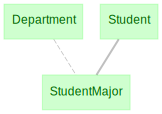

In [6]:
dj.Diagram(schema)

In [8]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course  : int unsigned   # course number, e.g. 1010
    ---
    course_name :  varchar(200)  # e.g. "Neurobiology of Sensation and Movement."
    credits     :  decimal(3,1)  # number of credits earned by completing the course
    """
    
@schema
class Term(dj.Manual):
    definition = """
    term_year : year
    term      : enum('Spring', 'Summer', 'Fall')
    """

@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium   :  varchar(12)
    """
    
@schema
class CurrentTerm(dj.Manual):
    definition = """
    -> Term
    """

@schema
class Enroll(dj.Manual):
    definition = """
    -> Student
    -> Section
    """

@schema
class LetterGrade(dj.Manual):
    definition = """
    grade : char(2)
    ---
    points : decimal(3,2)
    """

@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """

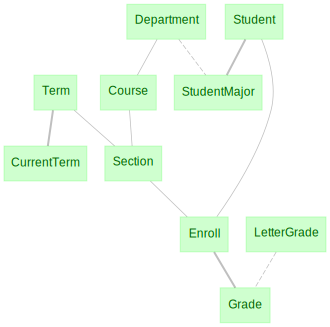

In [9]:
dj.Diagram(schema)

In [10]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()

In [11]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [12]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(100,300), yield_students()))

In [13]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Barbara,Cruz,F,1995-11-15,877 Perez Route,South Nathanland,SC,37876,+1-440-738-5021x919
101,Charles,Lang,M,2003-01-18,1443 Gaines Shoal,South Derrickhaven,NY,17676,(685)341-0168x1216
102,Lisa,Howard,F,2001-03-22,20309 Sparks Point Suite 605,Kevinborough,WA,46193,+1-496-409-0832x7028
103,William,Cabrera,M,2007-10-07,1452 Little Squares,Alexandrabury,OK,78525,930.731.6737
104,Emma,Williams,F,2006-01-25,1515 Andrea Ferry Suite 616,North Victoriabury,SC,68350,(725)950-3537x1651
105,Jessica,Ruiz,F,1988-09-16,4624 Dunn Course Apt. 727,Heatherburgh,WV,39941,869.251.0923
106,Daniel,Bates,M,1994-10-31,72318 Martinez Throughway Apt. 037,Sarahborough,AR,18566,(609)547-7753x0172
107,Jennifer,Henderson,F,2004-07-03,2867 Brian Vista Apt. 094,Port Amy,NV,18620,209-483-8663x17357
108,Sherry,Martinez,F,2000-05-29,53980 Jennifer Orchard,Nicoleland,FL,88079,638-594-3126x4188
109,Jill,Wilson,F,1994-02-28,97226 Scott Estates Apt. 983,Washingtonville,MA,42090,(744)453-4573x3520


In [14]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [15]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [16]:
StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
100,PHYS,2007-01-27
101,CS,2013-05-30
102,CS,2020-04-17
105,CS,2020-11-25
106,CS,2011-09-24
109,BIOL,2012-12-01
111,BIOL,2010-08-27
112,BIOL,2018-03-31
115,BIOL,2014-04-17
117,PHYS,2018-05-03


In [17]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

In [18]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [19]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

In [21]:
LetterGrade()

grade,points
A,4.00
A-,3.67
B,3.00
B-,2.67
B+,3.33
C,2.00
C-,1.67
C+,2.33
D,1.00
D+,1.33


In [22]:
# Enrollment 
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

100%|██████████| 200/200 [00:10<00:00, 19.38it/s]


In [ ]:
# assign random grades
grades = LetterGrade.fetch('grade')

grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

In [23]:
Enroll()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section
169,BIOL,1006,2001,Spring,a
195,BIOL,1006,2001,Spring,a
171,BIOL,1006,2001,Spring,b
255,BIOL,1006,2001,Summer,a
110,BIOL,1006,2002,Fall,a
184,BIOL,1006,2002,Fall,a
245,BIOL,1006,2002,Fall,a
143,BIOL,1006,2002,Fall,b
148,BIOL,1006,2002,Fall,c
114,BIOL,1006,2003,Fall,a


# Queries

## Restriction

In [24]:
# Students from Texas
Student & {'home_state': 'TX'}

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
198,Gary,Arias,M,2001-08-26,5693 Rachel Fort,Johnsonhaven,TX,80473,(614)716-3998x72349


In [ ]:
Student & 'home_state="TX"'

In [ ]:
# Male students from outside Texas
(Student & 'sex="M"') - {'home_state': 'TX'}

In [ ]:
# Students from TX, OK, or NM
Student & [{'home_state':'OK'}, {'home_state':'NM'}, {'home_state':'TX'}] 

In [25]:
# Millenials
millennials = Student & 'date_of_birth between "1981-01-01" and "1996-12-31"'

In [26]:
millennials

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Barbara,Cruz,F,1995-11-15,877 Perez Route,South Nathanland,SC,37876,+1-440-738-5021x919
105,Jessica,Ruiz,F,1988-09-16,4624 Dunn Course Apt. 727,Heatherburgh,WV,39941,869.251.0923
106,Daniel,Bates,M,1994-10-31,72318 Martinez Throughway Apt. 037,Sarahborough,AR,18566,(609)547-7753x0172
109,Jill,Wilson,F,1994-02-28,97226 Scott Estates Apt. 983,Washingtonville,MA,42090,(744)453-4573x3520
111,Tina,Ray,F,1995-04-14,1407 Brandon Ridge,South Samuelfort,KS,22351,001-839-569-7092x170
113,Joshua,Foster,M,1995-12-05,5977 Hannah Gateway Apt. 455,Alexaburgh,IL,25439,954-732-8286
115,Sarah,Cantu,F,1993-11-22,0746 Gloria Mills Suite 175,Howardton,NM,71040,605.358.8159
116,Alfred,Snyder,M,1992-07-17,31613 Frank Road Apt. 815,Martinside,PA,33470,880.832.0572x198
117,Lauren,Mack,F,1992-11-30,09867 Ronald Islands,Lewisborough,NC,52039,660-258-8038
120,Wanda,Frey,F,1996-01-22,917 Woods Meadow,South Lisa,FL,96002,(624)972-1055x79856


In [27]:
# Students who have taken classes
Student & Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Barbara,Cruz,F,1995-11-15,877 Perez Route,South Nathanland,SC,37876,+1-440-738-5021x919
101,Charles,Lang,M,2003-01-18,1443 Gaines Shoal,South Derrickhaven,NY,17676,(685)341-0168x1216
102,Lisa,Howard,F,2001-03-22,20309 Sparks Point Suite 605,Kevinborough,WA,46193,+1-496-409-0832x7028
104,Emma,Williams,F,2006-01-25,1515 Andrea Ferry Suite 616,North Victoriabury,SC,68350,(725)950-3537x1651
105,Jessica,Ruiz,F,1988-09-16,4624 Dunn Course Apt. 727,Heatherburgh,WV,39941,869.251.0923
106,Daniel,Bates,M,1994-10-31,72318 Martinez Throughway Apt. 037,Sarahborough,AR,18566,(609)547-7753x0172
107,Jennifer,Henderson,F,2004-07-03,2867 Brian Vista Apt. 094,Port Amy,NV,18620,209-483-8663x17357
108,Sherry,Martinez,F,2000-05-29,53980 Jennifer Orchard,Nicoleland,FL,88079,638-594-3126x4188
109,Jill,Wilson,F,1994-02-28,97226 Scott Estates Apt. 983,Washingtonville,MA,42090,(744)453-4573x3520
110,Summer,Brown,F,2000-08-14,5210 Herrera Cliff,East Joan,IA,64238,(549)359-7826x6789


In [28]:
# Millenials who have never enrolled
millennials - Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
168,Susan,Smith,F,1994-12-30,560 Lopez Branch Apt. 788,New Jasonfurt,FL,96037,001-232-425-7123x362
194,Christopher,Hernandez,M,1990-07-31,534 Amanda Hill Apt. 376,South Amandaville,WA,25494,(787)577-0513x07471
208,Christine,Barron,F,1996-07-06,1691 Burke Lake,Caldwellville,CA,88933,283.966.1713
226,Joseph,Evans,M,1990-10-07,539 Thomas Crossroad Apt. 694,West Emily,WV,81719,726.837.3774x03599
284,Monica,Burton,F,1995-08-03,550 Alison Dale Suite 863,Randallland,WI,14516,637.445.3376x631
289,Jerry,Ramirez,M,1989-06-12,95936 Lara Skyway,Randyberg,AS,34131,996.978.0755
292,Amanda,Dougherty,F,1995-02-26,37994 Smith Island,Cartershire,AL,59865,566.392.0752x22812


In [29]:
# Students who have not taken classes
Student - Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
103,William,Cabrera,M,2007-10-07,1452 Little Squares,Alexandrabury,OK,78525,930.731.6737
127,Cheryl,Hawkins,F,2007-08-09,2653 Lance Drive,Crossborough,RI,72648,7447138304
128,Michael,Dixon,M,1997-02-27,022 Smith Courts,South Zachary,ID,97892,4037310777
133,Paul,Hall,M,1998-05-30,54772 Zachary Viaduct Apt. 395,Sarahside,IA,92005,+1-609-773-3976
153,April,Sims,F,2000-07-22,619 Levy Burgs Apt. 847,South Oscar,NH,75765,940-428-5035x9354
165,Cindy,Barnes,F,2005-01-03,8306 Barry Gateway,Elizabethmouth,ND,32608,001-297-459-1311
168,Susan,Smith,F,1994-12-30,560 Lopez Branch Apt. 788,New Jasonfurt,FL,96037,001-232-425-7123x362
175,Danielle,Paul,F,2003-02-15,35339 James Crescent Suite 466,New Stephen,MA,72663,001-901-663-8095
178,Frank,Perkins,M,2003-06-03,95950 Jasmine Locks,East Gary,SD,76339,+1-461-513-2595x005
194,Christopher,Hernandez,M,1990-07-31,534 Amanda Hill Apt. 376,South Amandaville,WA,25494,(787)577-0513x07471


In [30]:
# Students who have taken Biology classes but no MATH courses
(Student & (Enroll & 'dept="BIOL"')) - (Enroll & 'dept="MATH"')

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
101,Charles,Lang,M,2003-01-18,1443 Gaines Shoal,South Derrickhaven,NY,17676,(685)341-0168x1216
119,Sarah,Lin,F,2001-09-13,6469 Jesus Stravenue Suite 497,Lake Thomaschester,WY,35503,408.292.3880
130,Pamela,Blevins,F,1990-08-13,3266 Michael Villages Apt. 068,New Nathanland,VI,97258,274.333.7892
136,Stephanie,Morgan,F,2003-12-25,39130 Lewis Divide,West Nicoleside,DC,09460,(926)699-2959x61499
142,Gregory,Cross,M,2000-03-29,8455 Beth Spring Apt. 986,Timothymouth,MO,81976,705.668.5361
158,Robyn,Sherman,F,2001-01-12,78443 Shelley Glens,Arnoldmouth,PR,37442,+1-301-611-8059
161,Angela,Hall,F,1993-03-31,992 Richards Trail,Timothybury,ND,02774,991-551-7347
166,Kelsey,Kelly,F,2007-10-08,905 Danny Rapid,New Douglas,CO,85978,+1-984-965-9423
170,Wesley,Porter,M,2004-04-23,407 Hunt Course Suite 409,Bridgetbury,AZ,94654,680-470-1676x41754
179,Brandon,Schroeder,M,2001-05-22,248 Rose Mountain,Lake Tamiburgh,MP,21021,+1-845-637-4872x588


In [31]:
# Students who have not selected a major
Student - StudentMajor

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
103,William,Cabrera,M,2007-10-07,1452 Little Squares,Alexandrabury,OK,78525,930.731.6737
104,Emma,Williams,F,2006-01-25,1515 Andrea Ferry Suite 616,North Victoriabury,SC,68350,(725)950-3537x1651
107,Jennifer,Henderson,F,2004-07-03,2867 Brian Vista Apt. 094,Port Amy,NV,18620,209-483-8663x17357
108,Sherry,Martinez,F,2000-05-29,53980 Jennifer Orchard,Nicoleland,FL,88079,638-594-3126x4188
110,Summer,Brown,F,2000-08-14,5210 Herrera Cliff,East Joan,IA,64238,(549)359-7826x6789
113,Joshua,Foster,M,1995-12-05,5977 Hannah Gateway Apt. 455,Alexaburgh,IL,25439,954-732-8286
114,George,Sanchez,M,2007-12-26,55281 Small Glens Suite 794,East Justin,FL,95631,4979279923
116,Alfred,Snyder,M,1992-07-17,31613 Frank Road Apt. 815,Martinside,PA,33470,880.832.0572x198
125,Ariel,Hawkins,F,2002-01-02,20104 Kimberly Club,Heatherside,NV,33834,(953)452-1914x02596
126,Tara,Duncan,F,1992-10-19,95977 Victoria Creek Suite 442,New Paul,GU,91322,+1-386-829-2550x2027


In [32]:
# Students who are taking courses in the current term
Student - (Enroll & CurrentTerm)

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Barbara,Cruz,F,1995-11-15,877 Perez Route,South Nathanland,SC,37876,+1-440-738-5021x919
101,Charles,Lang,M,2003-01-18,1443 Gaines Shoal,South Derrickhaven,NY,17676,(685)341-0168x1216
103,William,Cabrera,M,2007-10-07,1452 Little Squares,Alexandrabury,OK,78525,930.731.6737
105,Jessica,Ruiz,F,1988-09-16,4624 Dunn Course Apt. 727,Heatherburgh,WV,39941,869.251.0923
106,Daniel,Bates,M,1994-10-31,72318 Martinez Throughway Apt. 037,Sarahborough,AR,18566,(609)547-7753x0172
107,Jennifer,Henderson,F,2004-07-03,2867 Brian Vista Apt. 094,Port Amy,NV,18620,209-483-8663x17357
109,Jill,Wilson,F,1994-02-28,97226 Scott Estates Apt. 983,Washingtonville,MA,42090,(744)453-4573x3520
110,Summer,Brown,F,2000-08-14,5210 Herrera Cliff,East Joan,IA,64238,(549)359-7826x6789
111,Tina,Ray,F,1995-04-14,1407 Brandon Ridge,South Samuelfort,KS,22351,001-839-569-7092x170
112,Craig,Nolan,M,2001-12-08,425 Nathan Turnpike Apt. 256,Seanstad,CA,17904,898.625.6573x46193


In [33]:
(Student - (Enroll & CurrentTerm)).make_sql()

'SELECT `student_id`,`first_name`,`last_name`,`sex`,`date_of_birth`,`home_address`,`home_city`,`home_state`,`home_zip`,`home_phone` FROM `university`.`student` WHERE ((`student_id`) not in (SELECT `student_id` FROM `university`.`enroll` WHERE ((`term_year`,`term`) in (SELECT `term_year`,`term` FROM `university`.`current_term`))))'

In [ ]:
# Ungraded courses
Enroll - Grade

In [ ]:
# Ungraded courses in the current term
(Enroll & CurrentTerm) - Grade

In [ ]:
# Students who have taken classes and have chosen a major
(Student & Enroll & StudentMajor)

In [ ]:
#Students who have taken classes or have chosen a major
Student & [Enroll, StudentMajor]

In [ ]:
# Enrollment in courses from the same department as the students' major
Enroll & StudentMajor

## Join

In [34]:
# Grade point values
Grade * LetterGrade

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade,points


In [35]:
# Graded enrollments with complete course and student information
Student * Enroll * Course * Section * Grade * LetterGrade

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881,"course_name e.g. ""Neurobiology of Sensation and Movement.""",credits number of credits earned by completing the course,auditorium,points


In [ ]:
# Enrollment with major information
Enroll * StudentMajor.proj(major='dept')

In [ ]:
# Enrollment outside chosen major
Enroll * StudentMajor.proj(major='dept') & 'major<>dept'

In [ ]:
# Enrollment not matching major 
Enroll - StudentMajor 

In [ ]:
# Total grade points
(Course * Grade * LetterGrade).proj(total='points*credits')

## Aggr

In [ ]:
# Students in each section
Section.aggr(Enroll, n='count(*)')

In [ ]:
# Average grade in each course
Course.aggr(Grade*LetterGrade, avg_grade='avg(points)')

In [ ]:
# Fraction graded in each section
(Section.aggr(Enroll,n='count(*)') * Section.aggr(Grade, m='count(*)')).proj(
    'm','n',frac='m/n')

In [ ]:
# Student GPA
Student.aggr(Course * Grade * LetterGrade, 
             gpa='sum(points*credits)/sum(credits)')

In [ ]:
# Average GPA for each major
gpa = Student.aggr(Course * Grade * LetterGrade,
                   gpa='sum(points*credits)/sum(credits)')
Department.aggr(StudentMajor*gpa, avg_gpa='avg(gpa)')